In [51]:
import pandas as pd
from pandas import DataFrame
import cPickle as pickle
import re
import seaborn as sns
import time


from matplotlib import pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

In [52]:
with open('df_amenities_neighbourhood_all.pkl') as f:
    df = pickle.load(f)

In [3]:
df.head(2)

,id,name,summary,latitude,longitude,space,description,neighborhood_overview,notes,transit,...,atm,cinema,hospital,nightclub,park,mall,gallery,museum,supermarket,bus_stop
0,8238835,Cozy BR + EnSuite @ York University,We are located at York University. Close to Yo...,43.768740,-79.502254,The house is located less than 100 meters from...,We are located at York University. Close to Yo...,"Our house is ideal for students, professionals...","Please note, this room does not have a window....",The bus stop is right in front of our home on ...,...,509,5812,5400,1060,3269,7227,-1,9607,1709,72
1,16162206,"Large sunny bedroom, 3d floor (3A)",This room is one of 4 bedrooms available in a ...,43.765573,-79.492943,NaN,This room is one of 4 bedrooms available in a ...,NaN,NaN,NaN,...,1212,5480,4588,1151,2694,6488,-1,9476,1213,77


### Price - the variable to be predicted

We start by examining the price column - statistical moments, ranges, basic plots

In [53]:
get_numeric_price = lambda x:int(re.sub(',', '', x.split('.')[0][1:])) # Function to convert price string to numeric: $45.00 -> 45 
df['price'] = df['price'].apply(get_numeric_price)

In [63]:
highest_indices = df.price.sort_values(ascending=False)[:5].index
for i in highest_indices:
    print 'Listed Price:', df.ix[i,'price'], 'URL: https://www.airbnb.com/rooms/'+ str(df.ix[i,'id'])

# Except for the 1st one (which was probably scraped wrongly or wrongly posted by the host), 
# the remaining are actually that expensive!  
# There could be minor difference between the current price and the price when the data was scraped

Listed Price: 5500 URL: https://www.airbnb.com/rooms/11219978
Listed Price: 4000 URL: https://www.airbnb.com/rooms/13788645
Listed Price: 2999 URL: https://www.airbnb.com/rooms/5371576
Listed Price: 2780 URL: https://www.airbnb.com/rooms/9526699
Listed Price: 2500 URL: https://www.airbnb.com/rooms/16062958


In [64]:
lowest_indices = df.price.sort_values(ascending=True)[:5].index
for i in lowest_indices:
    print 'Listed Price:', df.ix[i,'price'], 'URL: https://www.airbnb.com/rooms/'+ str(df.ix[i,'id'])

# There could be minor difference between the current price and the price when the data was scraped
# There are indeed cheap airbnbs

Listed Price: 13 URL: https://www.airbnb.com/rooms/10023011
Listed Price: 15 URL: https://www.airbnb.com/rooms/6846217
Listed Price: 15 URL: https://www.airbnb.com/rooms/15481128
Listed Price: 15 URL: https://www.airbnb.com/rooms/10361301
Listed Price: 15 URL: https://www.airbnb.com/rooms/13913400


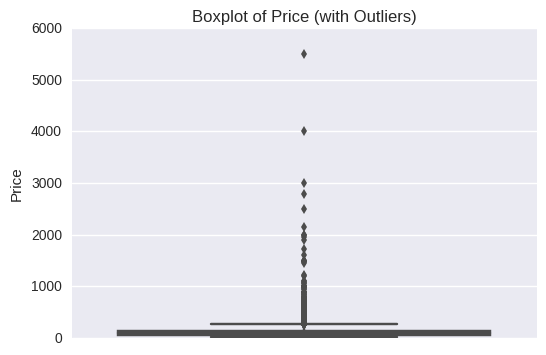

In [65]:
ax = sns.boxplot(y = df['price'])
ax.set(ylabel='Price', title = 'Boxplot of Price (with Outliers)')

As seen in the the box above, there seems to be a number with extremely high prices. These are discarded from the model. <br> For outlier removal, the Inter-Quartile Metric is used as described below:
<code>
IQR = 3rd quartile - 1st quartile
Any value greater than (3rd quartile + 1.5\*IQR) is considered an outlier
Any value less than (1st quartile - 1.5\*IQR) is considered an outlier

Reference: http://www.mathwords.com/o/outlier.htm
</code>

In [66]:
iqr = df['price'].quantile(q=0.75)-df['price'].quantile(0.25)
lower_limit = max(0, df['price'].quantile(0.25)-1.5*iqr) # The price cannot be negative. So a constaint is kept
upper_limit = df['price'].quantile(0.75)+1.5*iqr

print "Only prices between", lower_limit, "and", upper_limit,"are retained in the dataset."

remove_index = df[df['price'] > upper_limit].index
df.drop(remove_index, inplace=True)
df.reset_index(inplace=True)
print "The number of rows removed = ", len(remove_index)

Only prices between 0 and 269.5 are retained in the dataset.
The number of rows removed =  562


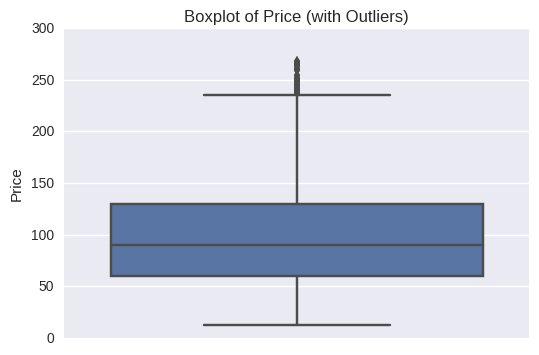

In [67]:
ax = sns.boxplot(y = df['price'])
ax.set(ylabel='Price', title = 'Boxplot of Price (with Outliers)')

In [68]:
# Some descriptive statistics of the price column after removing outliers
print df.price.describe()

count    9232.000000
mean      101.510399
std        52.898753
min        13.000000
25%        60.000000
50%        90.000000
75%       130.000000
max       268.000000
Name: price, dtype: float64


<code>
From the histogram, we can see that price is approximately normally distributed but with a positive skewness
</code>

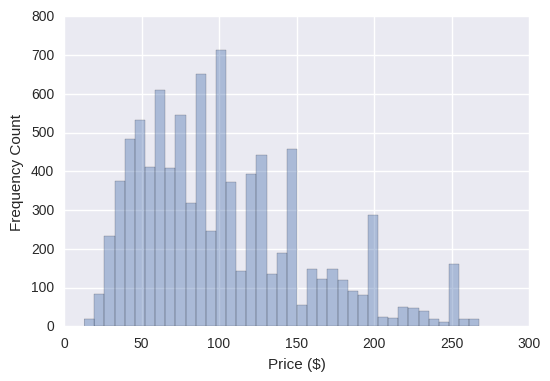

In [69]:
sns.distplot(df['price'], kde=False, axlabel='Price ($)')
plt.ylabel('Frequency Count')

Skewness =  0.873696815331


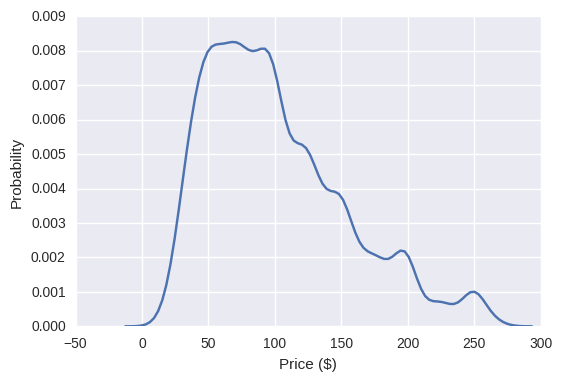

In [70]:
sns.distplot(df['price'], hist=False, axlabel='Price ($)') # Density PLot
plt.ylabel('Probability')
print "Skewness = ", df['price'].skew()

In [ ]:
# A variable called host experience that represents
# the difference in terms of the number of months since the host joined airbnb and
# the day the scraping was carried out

df.dropna(subset=['host_since'], inplace=True) # Drop 1 row which had that attribute as NA
df.reset_index(inplace=True)

calculate_host_experience = lambda x: int(time.mktime(time.strptime('2017-02-01', "%Y-%m-%d"))/(24*60*60*30)) - int(time.mktime(time.strptime(x, "%Y-%m-%d"))/(24*60*60*30))
df['host_exp'] = df['host_since'].apply(calculate_host_experience)

Mean: 30.6725519931
Median: 27.0
Max: 103


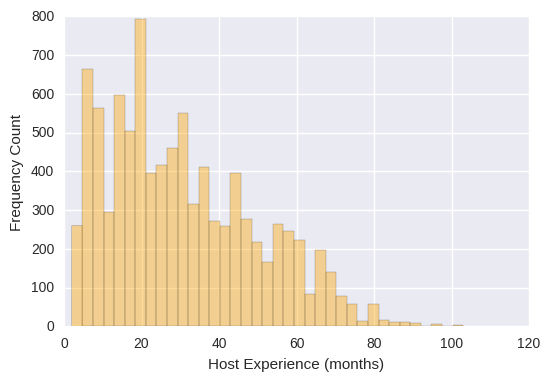

In [74]:
print "Mean:", df['host_exp'].mean()
print "Median:", df['host_exp'].median()
print "Max:", df['host_exp'].max()
sns.distplot(df['host_exp'], kde=False, axlabel='Host Experience (months)', color='orange')
plt.ylabel('Frequency Count')

<code>
Most hosts have an experience of 2 to 2.5 years (24-30 months). However, the maximum experience is 8.5 years (103 months)
</code>

In [79]:
# Most hosts respond within a hour, only a very small percent of the hosts take over a day to reply
df['host_response_time'].value_counts(dropna=False)

within an hour        4094
within a few hours    2047
NaN                   1753
within a day          1163
a few days or more     175
Name: host_response_time, dtype: int64

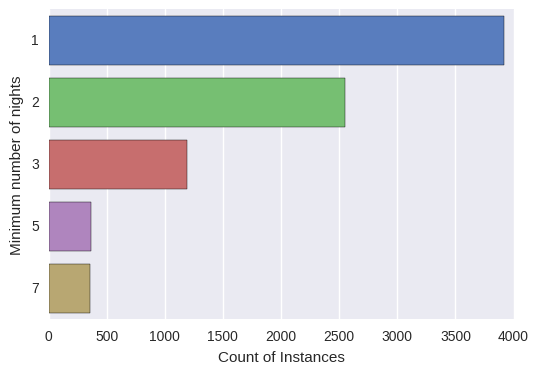

In [97]:
min_nights = df['minimum_nights'].value_counts(dropna=False)[:5]
sns.barplot(x=min_nights, y=min_nights.index, palette="muted",orient = 'h')
plt.xlabel('Count of Instances')
plt.ylabel('Minimum number of nights')

<code>
Most people rent their house with a minimum 1-night stay condition. Min 2 or 3 night listings are also common. 
Beyond that the frequency is very less (because these are vacation rentals)
</code>

In [107]:
df.guests_included.value_counts()[:4]

1    6064
2    1980
0     403
4     398
Name: guests_included, dtype: int64

<code>
Most listings (>50%) indicate that the price mentioned is accomodation for 1 person.
However, there are some mentions of 0 guests included. This cannot obviously be correct. It could be that the advertisement posters had an ambiguity of number of extra guests that can be included, rather than the actual number of guests that the price covers for.  
</code>

In [108]:
df.extra_people.value_counts(dropna=False) [:5]

$0.00     5010
$20.00     834
$10.00     822
$25.00     573
$15.00     554
Name: extra_people, dtype: int64

<code>
Most records (>50%) have a value $0. Not very sure if the hosts intend to say "no extra charge for extra guests" or they mention $0 because the house/room/bed cannot accomodate more than 1 person.
</code>

Max Reviews: 401


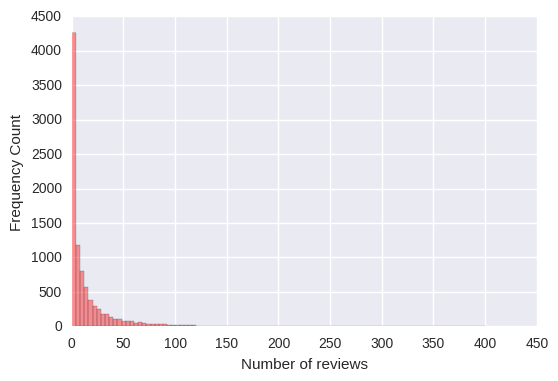

In [104]:
sns.distplot(df['number_of_reviews'], kde=False, axlabel='Number of reviews', color='red', bins=100)
plt.ylabel('Frequency Count')
print "Max Reviews:", df['number_of_reviews'].max()

<code>
Most hosts/listings do not have even 1 traveller review. The maximum number of reviews that a listing has received is 401
</code>

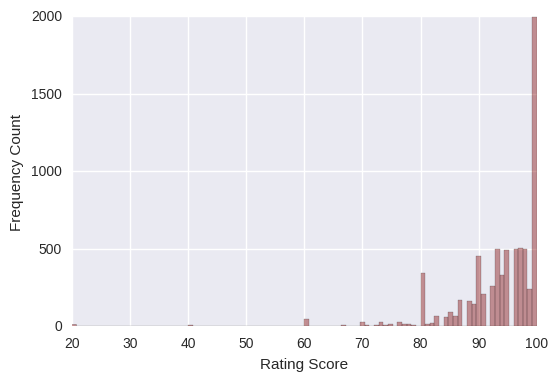

In [153]:
sns.distplot(df['review_scores_rating'].dropna(), kde=False, axlabel='Rating Score', color='maroon', bins=100)
plt.ylabel('Frequency Count')

<code>
Among the listings that have been rated, most of them have been rated very high (scores greater than 90). There were 1993 listings that had a perfect rating of 100.
</code>

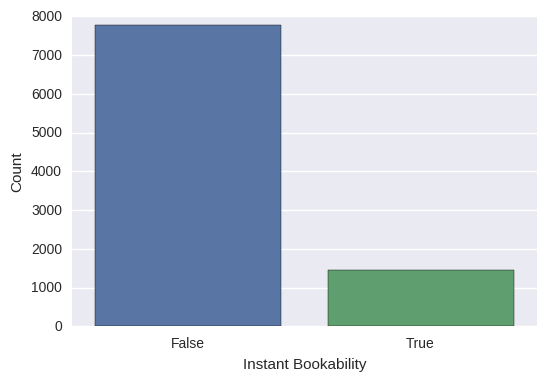

In [160]:
instant_booking = df.instant_bookable.value_counts()
instant_booking_dict = {'f':'False', 't':'True'}
sns.barplot([instant_booking_dict[i] for i in instant_booking.index], instant_booking.values)
plt.xlabel('Instant Bookability')
plt.ylabel('Count')

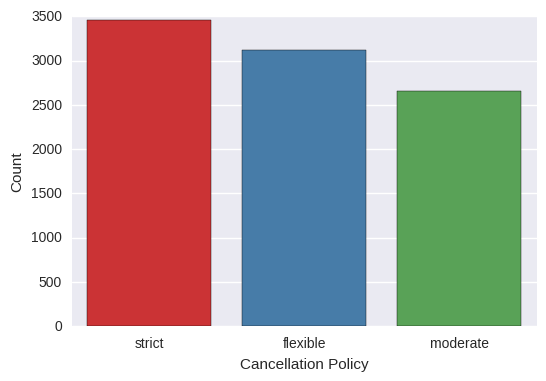

In [169]:
sns.barplot(pd.Series(df['cancellation_policy'].value_counts()).index, pd.Series(df['cancellation_policy'].value_counts()).values, palette='Set1')
plt.xlabel('Cancellation Policy')
plt.ylabel('Count')

Frequency Counts
1    5604
2    1335
Name: calculated_host_listings_count, dtype: int64
Max: 62


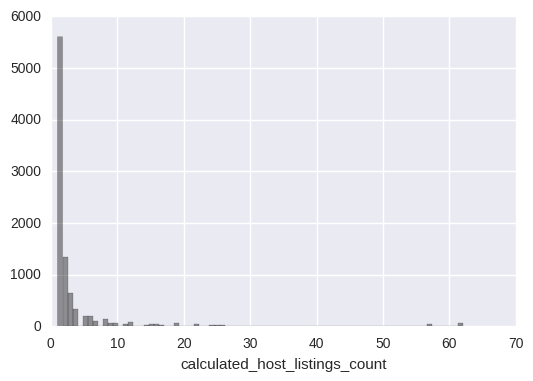

In [180]:
sns.distplot(df['calculated_host_listings_count'], kde=False, bins=80, color='black')
print "Frequency Counts\n", df['calculated_host_listings_count'].value_counts()[:2]
print "Max:", df['calculated_host_listings_count'].max()

<code>
5604 hosts out of the total have just 1 property listed, 1335 have two. 
The maximum number of properties listed by a single host is 62. It is possible that this user name is owned by a real-estate agency with a large number of houses/appartments to rent.
<code>

In [ ]:
u'Free parking on premises',
                      u'Elevator in building',
                                  u'Internet',
                       u'Family/kid friendly',
                         u'Wireless Internet',
                  u'Buzzer/wireless intercom',
                                   u'Kitchen',
                                   u'Doorman',
                     u'Wheelchair accessible',
                                  u'Cable TV',
                                   u'Hot tub',
                                       u'Gym',
                                      u'Pool',
                                        u'TV',
                                     u'Dryer',
                                    u'Washer',
                                u'Essentials',
                                   u'Shampoo',
                                   u'Heating',
                          u'Air conditioning',
                              u'Pets allowed',
                       u'Suitable for events',
                           u'Smoking allowed',
                          u'Indoor fireplace',
                                 u'Breakfast',
                 u'Laptop friendly workspace',
                                      u'Iron',
                                   u'Hangers',
                                u'Hair dryer',
                       u'Private living room',
                          u'Private entrance',
                 u'Paid parking off premises',
                    u'Free parking on street',

### Amenities

In [182]:
# Discard amenities that do not have much variation across records. 
# Combine some amenities like parkings